
### *Development Notebook*
# Breakline/Mesh Data Dictionary 

---

### HEC-RAS Computational Mesh & HDF File Components

![](overview.PNG)


---

###  We need to identify Cell/Face Pairs at a breakline


![](breakline.png)

---

###  Incorporate Dircetionality


![](direction.png)

---

In [1]:
import h5py
import numpy as np
import pathlib as pl
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from collections import OrderedDict
import matplotlib.pyplot as plt

#### Functions
Temporarily stored in cells during development. Move to `.py` for production

In [2]:
def hdfData(hdfFile:str, path:str):
    '''Get Data Array only from HDF'''
    with h5py.File(hdfFile,'r') as hf:
        binary_data = np.array(hf[path])
        return binary_data 

def mapTable(idxs, infoArray):
    '''From Info, get position of indexed data to build table'''
    table_map = {}
    for idx in idxs:
        start = infoArray[idx,0]
        stop = start + infoArray[idx,1]
        table_map[idx] = (start, stop)
    return table_map

def hdfDataSet(hdfFile:str, path:str):
    '''Get Data from HDF'''
    p = pl.Path(path).name
    with h5py.File(hdfFile,'r') as hf:
        values = np.array(hf[path].value)
        rowData = np.array(hf[path].attrs['Row'])
        colData = np.array(hf[path].attrs['Column'])
        return  {'path':p, 'data':values, 'rowData':rowData, 'colData':colData}
    
def printDescription(d):
    print(d['path'], '\n', d['rowData'], '\t', d['colData'])
    
def get_groups(sharePair: list):
    spairs = sharePair.copy()
    g1 = spairs[0]
    spairs.remove(spairs[0])
    
    for i in range(3):
        
        for p in spairs:
            if i%2==0:
                a, b = p[0], p[1]
            else:
                a, b = p[1], p[0]
                
            if (a in g1):
                g1.append(b)
                spairs.remove(p)
                
    g1 = list(set(g1))
    g2 =  list(set([item for sublist in spairs for item in sublist]))
    
    return g1, g2

def get_point_combos(sortedPointList):
    combos = []
    for i, p in enumerate(sortedPointList):
        if len(sortedPointList) > i+1:
            fpA = np.array(sortedPointList[i])
            fpB = np.array(sortedPointList[i+1])
            combos.append(np.array([fpA, fpB]))
            
    return combos

### Enter HEC-RAS data info

In [3]:
# RAS Plan file (.hdf)
ras_data_file = r'C:\Data\Breaklines\P01.p01.hdf'

# RAS domain (2d Flow area name)
RasDomain = 'P01'

#### HDF Tables

In [4]:
flowAreaContents = hdfData(ras_data_file, '/Geometry/2D Flow Areas/{}'.format(RasDomain))
breakLineContents = hdfData(ras_data_file, '/Geometry/2D Flow Area Break Lines')
geomData, attrData, bLineData={},{},{}

for i, table in enumerate(flowAreaContents):
    table_path = '/Geometry/2D Flow Areas/{}/{}'.format(RasDomain,table)
    geomData[table] = hdfDataSet(ras_data_file, table_path)
    
for i, table in enumerate(breakLineContents):
    print(table)
    bLineData[table] = hdfData(ras_data_file, '/Geometry/2D Flow Area Break Lines/{}'.format(table))

bLineData

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Attributes
Polyline Info
Polyline Parts
Polyline Points


{'Attributes': array([(b'Breakline 1', nan, nan, 1, 0), (b'Breakline 2', nan, nan, 1, 0),
        (b'Breakline 3', nan, nan, 1, 0), (b'Breakline 5', nan, nan, 1, 0),
        (b'Breakline 6', nan, nan, 1, 0), (b'Breakline 7', nan, nan, 1, 0),
        (b'Breakline 8', nan, nan, 1, 0), (b'Breakline 9', nan, nan, 1, 0),
        (b'Breakline 10', nan, nan, 1, 0),
        (b'Breakline 11', nan, nan, 1, 0),
        (b'Breakline 12', nan, nan, 1, 0),
        (b'Breakline 13', nan, nan, 1, 0),
        (b'Breakline 14', nan, nan, 1, 0),
        (b'Breakline 15', nan, nan, 1, 0),
        (b'Breakline 16', nan, nan, 1, 0),
        (b'Breakline 17', nan, nan, 1, 0),
        (b'Breakline 18', nan, nan, 1, 0),
        (b'Breakline 19', nan, nan, 1, 0),
        (b'Breakline 20', nan, nan, 1, 0),
        (b'Breakline 21', nan, nan, 1, 0),
        (b'Breakline 22', nan, nan, 1, 0),
        (b'Breakline 23', nan, nan, 1, 0),
        (b'Breakline 24', nan, nan, 1, 0),
        (b'Breakline 25', nan, nan, 1

In [5]:
print(f'Geometry Tables\n\n{"Index":<11}{"Dataset":<40}{"Rows":<20}{"Columns":<45}')
geoKeys = list(geomData.keys())

for i, k in enumerate(geoKeys):
    printLine =  f'{i:<10} {k:<40}'
    for attrs in geomData[k].keys():
        if (attrs == 'rowData'):
            rowData  = geomData[k][attrs].flatten()
            data = [d.decode() for d in rowData]
            printLine += f'{data[0]:<20}'

        elif (attrs == 'colData'):
            colData  = geomData[k][attrs].flatten()
            data = [d.decode() for d in colData]
            for j, d in enumerate(data):
                printLine +=f'({j}) {d:<45}'
    print(printLine)


Geometry Tables

Index      Dataset                                 Rows                Columns                                      
0          Cells Center Coordinate                 Cell                (0) X                                            (1) Y                                            
1          Cells Face and Orientation Info         Cell                (0) Starting Index                               (1) Count                                        
2          Cells Face and Orientation Values       row                 (0) Face Index                                   (1) Orientation                                  
3          Cells FacePoint Indexes                 Cell                (0) Face Point Indexes                           
4          Cells Minimum Elevation                 Cell                (0) Minimum Elevation                            
5          Cells Surface Area                      Cell                (0) Surface Area                           

In [6]:
d0 =  geomData[geoKeys[0]]
d1 =  geomData[geoKeys[1]]
d2 =  geomData[geoKeys[2]]
d3 =  geomData[geoKeys[3]]
d4 =  geomData[geoKeys[4]]
d5 =  geomData[geoKeys[5]]
d6 =  geomData[geoKeys[6]]
d7 =  geomData[geoKeys[7]]
d8 =  geomData[geoKeys[8]]
d9 =  geomData[geoKeys[9]]
d10 = geomData[geoKeys[10]]
d11 = geomData[geoKeys[11]]
d12 = geomData[geoKeys[12]]
d13 = geomData[geoKeys[13]]
d14 = geomData[geoKeys[14]]
d15 = geomData[geoKeys[15]]
d16 = geomData[geoKeys[16]]
d17 = geomData[geoKeys[17]]
d18 = geomData[geoKeys[18]]
d19 = geomData[geoKeys[19]]
d20 = geomData[geoKeys[20]]
d21 = geomData[geoKeys[21]]
d22 = geomData[geoKeys[22]]
d23 = geomData[geoKeys[23]]

In [7]:
print('\nBreakline Data')
for k in bLineData.keys():print('\t',k)


Breakline Data
	 Attributes
	 Polyline Info
	 Polyline Parts
	 Polyline Points


### Read in Breakline data table

In [8]:
bLineAtts = bLineData['Attributes']
df_bLineAtts = pd.DataFrame(bLineAtts)
df_bLineAtts['Name'] = df_bLineAtts['Name'].apply(lambda x: x.decode())
df_bLineAtts

,Name,Cell Spacing Near,Cell Spacing Far,Near Repeats,Protection Radius
0,Breakline 1,NaN,NaN,1,0
1,Breakline 2,NaN,NaN,1,0
2,Breakline 3,NaN,NaN,1,0
3,Breakline 5,NaN,NaN,1,0
4,Breakline 6,NaN,NaN,1,0
5,Breakline 7,NaN,NaN,1,0
6,Breakline 8,NaN,NaN,1,0
7,Breakline 9,NaN,NaN,1,0
8,Breakline 10,NaN,NaN,1,0
9,Breakline 11,NaN,NaN,1,0


#### Breakline Tables

 1. __Poly Info__: table map
 - __Poly parts__: # of line segments for each breakline
 - __Poly Points__: x,y coordinates at each line part intersection

 ```python
bLinePolyInfo = {0 : 'Point Start Index' 1 : 'Point Count', 2 : , 3: }
```


In [9]:
bLinePolyInfo = bLineData['Polyline Info']
bLinePolyInfo[:]

array([[  0,  58,   0,   1],
       [ 58,  69,   1,   1],
       [127,  17,   2,   1],
       [144,  54,   3,   1],
       [198,  46,   4,   1],
       [244,  38,   5,   1],
       [282,  81,   6,   1],
       [363,   8,   7,   1],
       [371,   6,   8,   1],
       [377,   8,   9,   1],
       [385,   4,  10,   1],
       [389,   2,  11,   1],
       [391,   2,  12,   1],
       [393,   9,  13,   1],
       [402,   3,  14,   1],
       [405,   9,  15,   1],
       [414,   9,  16,   1],
       [423,   4,  17,   1],
       [427,  18,  18,   1],
       [445,   7,  19,   1],
       [452,  11,  20,   1],
       [463,  10,  21,   1],
       [473,  11,  22,   1],
       [484,  13,  23,   1],
       [497,   7,  24,   1],
       [504,   3,  25,   1],
       [507,   6,  26,   1],
       [513,   2,  27,   1],
       [515,   3,  28,   1],
       [518,   6,  29,   1],
       [524,   6,  30,   1],
       [530,   3,  31,   1],
       [533,  26,  32,   1],
       [559,   4,  33,   1],
       [563,  

In [10]:
bLinePolyParts = bLineData['Polyline Parts']
bLinePolyParts[:]

array([[ 0, 58],
       [ 0, 69],
       [ 0, 17],
       [ 0, 54],
       [ 0, 46],
       [ 0, 38],
       [ 0, 81],
       [ 0,  8],
       [ 0,  6],
       [ 0,  8],
       [ 0,  4],
       [ 0,  2],
       [ 0,  2],
       [ 0,  9],
       [ 0,  3],
       [ 0,  9],
       [ 0,  9],
       [ 0,  4],
       [ 0, 18],
       [ 0,  7],
       [ 0, 11],
       [ 0, 10],
       [ 0, 11],
       [ 0, 13],
       [ 0,  7],
       [ 0,  3],
       [ 0,  6],
       [ 0,  2],
       [ 0,  3],
       [ 0,  6],
       [ 0,  6],
       [ 0,  3],
       [ 0, 26],
       [ 0,  4],
       [ 0, 57],
       [ 0, 11],
       [ 0,  5],
       [ 0,  4],
       [ 0,  2],
       [ 0, 10],
       [ 0, 10],
       [ 0,  7],
       [ 0, 56]])

In [11]:
bLinePolyPoints = bLineData['Polyline Points']
bLinePolyPoints[:]

array([[ 208528.18329426, 1697155.62402011],
       [ 208368.5426732 , 1697201.9712972 ],
       [ 208244.94993431, 1697279.216759  ],
       ...,
       [ 195070.11542141, 1684100.3869298 ],
       [ 195115.13657081, 1684049.73813673],
       [ 195148.90243285, 1683993.46169999]])

### Use Info table to create a map of point data (coordinates) for breaklines 

In [12]:
bLinePointMap = {}
for idx, bLine in enumerate(df_bLineAtts.Name):
    start = bLinePolyInfo[idx,0]
    stop = start + bLinePolyInfo[idx,1]
    bLinePointMap[bLine] = (start, stop)
    
bLinePointMap    

{'Breakline 1': (0, 58),
 'Breakline 2': (58, 127),
 'Breakline 3': (127, 144),
 'Breakline 5': (144, 198),
 'Breakline 6': (198, 244),
 'Breakline 7': (244, 282),
 'Breakline 8': (282, 363),
 'Breakline 9': (363, 371),
 'Breakline 10': (371, 377),
 'Breakline 11': (377, 385),
 'Breakline 12': (385, 389),
 'Breakline 13': (389, 391),
 'Breakline 14': (391, 393),
 'Breakline 15': (393, 402),
 'Breakline 16': (402, 405),
 'Breakline 17': (405, 414),
 'Breakline 18': (414, 423),
 'Breakline 19': (423, 427),
 'Breakline 20': (427, 445),
 'Breakline 21': (445, 452),
 'Breakline 22': (452, 463),
 'Breakline 23': (463, 473),
 'Breakline 24': (473, 484),
 'Breakline 25': (484, 497),
 'Breakline 26': (497, 504),
 'Breakline 27': (504, 507),
 'Breakline 28': (507, 513),
 'Breakline 29': (513, 515),
 'Breakline 30': (515, 518),
 'Breakline 31': (518, 524),
 'Breakline 32': (524, 530),
 'Breakline 33': (530, 533),
 'Breakline 34': (533, 559),
 'Breakline 35': (559, 563),
 'Breakline 36': (563, 620

#### Use the map to Find Coordinates for each breakline

In [13]:
bLinePointCoords={}
for bline in bLinePointMap.keys():  
    blineCoords = bLinePolyPoints[bLinePointMap[bline][0]: bLinePointMap[bline][1]]
    bLinePointCoords[bline] = blineCoords
    print(bline, blineCoords, '\n')

Breakline 1 [[ 208528.18329426 1697155.62402011]
 [ 208368.5426732  1697201.9712972 ]
 [ 208244.94993431 1697279.216759  ]
 [ 208098.18355688 1697423.40828771]
 [ 207948.84233072 1697487.77950588]
 [ 207794.3514071  1697616.52194222]
 [ 207655.30957585 1697807.06074801]
 [ 207601.23775259 1697925.50378945]
 [ 207521.41744206 1698085.14441051]
 [ 207513.69289587 1698164.96472105]
 [ 207493.09410606 1698219.03654431]
 [ 207420.99834171 1698306.58140102]
 [ 207271.65711555 1698468.79687082]
 [ 207202.13619992 1698571.79081989]
 [ 207166.08831775 1698633.58718934]
 [ 207173.81286393 1698821.5511464 ]
 [ 207117.16619194 1698937.41933911]
 [ 207063.09436867 1699019.81449837]
 [ 206949.80102469 1699091.91026272]
 [ 206772.13646254 1699135.68269108]
 [ 206620.22038765 1699130.53299362]
 [ 206486.32825385 1699079.03601909]
 [ 206385.9091535  1698988.91631365]
 [ 206262.31641461 1698878.19781839]
 [ 206097.52609609 1698777.77871804]
 [ 205976.50820593 1698708.25780242]
 [ 205870.93940813 1698664

### Read in Face Point coordinates

In [14]:
fPointCoords = geomData[geoKeys[10]]['data']

#### Build map of Break lines to points

In [15]:
bLinePointCoords

{'Breakline 1': array([[ 208528.18329426, 1697155.62402011],
        [ 208368.5426732 , 1697201.9712972 ],
        [ 208244.94993431, 1697279.216759  ],
        [ 208098.18355688, 1697423.40828771],
        [ 207948.84233072, 1697487.77950588],
        [ 207794.3514071 , 1697616.52194222],
        [ 207655.30957585, 1697807.06074801],
        [ 207601.23775259, 1697925.50378945],
        [ 207521.41744206, 1698085.14441051],
        [ 207513.69289587, 1698164.96472105],
        [ 207493.09410606, 1698219.03654431],
        [ 207420.99834171, 1698306.58140102],
        [ 207271.65711555, 1698468.79687082],
        [ 207202.13619992, 1698571.79081989],
        [ 207166.08831775, 1698633.58718934],
        [ 207173.81286393, 1698821.5511464 ],
        [ 207117.16619194, 1698937.41933911],
        [ 207063.09436867, 1699019.81449837],
        [ 206949.80102469, 1699091.91026272],
        [ 206772.13646254, 1699135.68269108],
        [ 206620.22038765, 1699130.53299362],
        [ 206486.32

#### Search face point coordinate table to find which points share the breakline coordinates

In [16]:
fPointIDs_atBLine = {}
for bline, coords in bLinePointCoords.items():
    #print(bline)
    fPointIDs_atBLine[bline] = []
    for point in coords:
        idx = np.where(fPointCoords == point)
        print('fpointcoords:', fPointCoords)
        print('point', point)
        print('Idx:', idx)
        assert idx[0][0] == idx[0][1], 'Points not in the same array' # Since we are comparing floats, lets make sure we pick up the right ones
        fpointIdx = idx[0][0]
        fPointIDs_atBLine[bline].append(fpointIdx)
        print('\tFace Point ID = ', fpointIdx)

fpointcoords: [[ 193652.0562529  1712189.8319672 ]
 [ 193720.23536297 1712121.65285712]
 [ 193820.23536297 1712121.65285712]
 ...
 [ 179444.58776953 1652309.73805257]
 [ 180311.72976336 1651832.13297094]
 [ 180720.08963897 1651153.66075137]]
point [ 208528.18329426 1697155.62402011]
Idx: (array([107395, 107395], dtype=int64), array([0, 1], dtype=int64))
	Face Point ID =  107395
fpointcoords: [[ 193652.0562529  1712189.8319672 ]
 [ 193720.23536297 1712121.65285712]
 [ 193820.23536297 1712121.65285712]
 ...
 [ 179444.58776953 1652309.73805257]
 [ 180311.72976336 1651832.13297094]
 [ 180720.08963897 1651153.66075137]]
point [ 208368.5426732 1697201.9712972]
Idx: (array([], dtype=int64), array([], dtype=int64))


IndexError: index 0 is out of bounds for axis 0 with size 0

#### Map Breakline ID's to Facepoints

In [17]:
x = [x[0] for x in d10['data']]
y = [x[1] for x in d10['data']]
gdf = gpd.GeoDataFrame(gpd.GeoSeries(map(Point, zip(x, y))))

#### Choose a Test bLine

Breakline 12


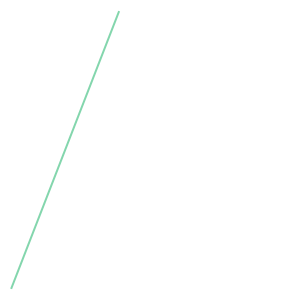

In [18]:
bLine = list(bLinePointMap.keys())[10]
print(bLine)
start_point = bLinePointCoords[bLine][0]
stop_point = bLinePointCoords[bLine][-1]
line = LineString([start_point,stop_point])
line

In [19]:
fpointsOnLine = {}
for xy in np.arange(0, fPointCoords.shape[0]):
    facePoint = Point(fPointCoords[xy])
    if line.intersects(facePoint.buffer(1)):
        fpointsOnLine[xy] = fPointCoords[xy]
        print(xy, facePoint)

108431 POINT (211499.585848742 1693918.44682231)
108432 POINT (211463.3014123406 1693825.429225388)
108433 POINT (211427.0169759393 1693732.411628465)
108434 POINT (211390.7325395379 1693639.394031542)
108435 POINT (211354.4481031366 1693546.37643462)
108436 POINT (211318.1636667353 1693453.358837697)
108437 POINT (211281.8792303338 1693360.341240774)
108438 POINT (211245.5947939325 1693267.323643852)
108439 POINT (211209.3103575312 1693174.306046929)
108440 POINT (211173.0259211298 1693081.288450007)
108570 POINT (206433.83557524 1680890.69372786)


In [20]:
sortPoints = dict()
for fp, xy in fpointsOnLine.items():
    a = Point(start_point)
    b = Point(xy)
    distance_from_start =  a.distance(b)
    sortPoints[fp] = distance_from_start
    
sortedPoints = OrderedDict(sorted(sortPoints.items(), key=lambda x: x[1]))
sortedPoints

OrderedDict([(108431, 0.0),
             (108432, 99.84404670392793),
             (108433, 199.6880934078453),
             (108434, 299.5321401117732),
             (108435, 399.3761868156906),
             (108436, 499.22023351961843),
             (108437, 599.0642802237844),
             (108438, 698.9083269277018),
             (108439, 798.7523736316297),
             (108440, 898.5964203355471),
             (108570, 13977.989001406455)])

In [21]:
sortedPointList = list(sortedPoints.keys())
sortedPointList

[108431,
 108432,
 108433,
 108434,
 108435,
 108436,
 108437,
 108438,
 108439,
 108440,
 108570]

In [22]:
pointCombos = get_point_combos(sortedPointList)
pointCombos

[array([108431, 108432]),
 array([108432, 108433]),
 array([108433, 108434]),
 array([108434, 108435]),
 array([108435, 108436]),
 array([108436, 108437]),
 array([108437, 108438]),
 array([108438, 108439]),
 array([108439, 108440]),
 array([108440, 108570])]

In [23]:
searchTable = d17['data']
cells = []
faceCellCombos = {}

print('Face Points','\t', 'Face','\t', 'Common Cells', '\t','aCell (min el) bCell (min el)', '\tOrthogonal Dir')
for combo in pointCombos:
    aFaces = np.where(searchTable == combo[0])[0]
    bFaces = np.where(searchTable == combo[1])[0] # only one pointCombo found (need at least 5) so combo[1] does not exist for list(bLinePointMap.keys())[2] testing with other keys in the model
#     print(aFaces)
    commonFace = [f for f in aFaces if f in bFaces][0] #len(aFaces) might be longer/not equal to len(bFaces) causing this to give list index out of range errors
#     print(commonFace)
    faceCells = d16['data'][commonFace]
    for c in faceCells: cells.append(c)
    
    aCellMinElev = d4['data'][faceCells[0]]
    bCellMinElev = d4['data'][faceCells[1]]  
    
    
    # Read position info from d11
    startFind = d11['data'][combo[0]][0]
    stopFind = startFind+ d11['data'][combo[0]][1]
    startFind, stopFind 
    
    fPointFaces = d12['data'][startFind:stopFind]
    idx = np.argwhere(fPointFaces==commonFace)
    orthoDir = fPointFaces[idx[0][0]][-1]

    faceCellCombos[commonFace] = faceCells

    print(combo,'\t', commonFace, '\t',faceCells,'\t', aCellMinElev,'\t', bCellMinElev, '\t', orthoDir)

Face Points 	 Face 	 Common Cells 	 aCell (min el) bCell (min el) 	Orthogonal Dir
[108431 108432] 	 66742 	 [100049 100050] 	 776.7569 	 776.07117 	 -1
[108432 108433] 	 67419 	 [100053 100054] 	 776.5232 	 774.4101 	 -1
[108433 108434] 	 68071 	 [100055 100056] 	 775.6476 	 774.27673 	 -1
[108434 108435] 	 68072 	 [100057 100058] 	 775.3563 	 773.2002 	 -1
[108435 108436] 	 68761 	 [100060 100059] 	 771.80255 	 773.4558 	 1
[108436 108437] 	 69379 	 [100061 100062] 	 774.7764 	 772.03375 	 -1
[108437 108438] 	 69433 	 [100063 100064] 	 776.29254 	 774.7358 	 -1
[108438 108439] 	 70795 	 [100065 100066] 	 777.67255 	 774.595 	 -1
[108439 108440] 	 70116 	 [100068 100067] 	 774.3367 	 776.8724 	 1


IndexError: list index out of range

### Incomplete

Directionality: Figure out which cell is hiegher, assume downstream is the lower cells direction

In [ ]:
crossCellPairs=[]
for combo in faceCellCombos:
    crossCells = str(faceCellCombos[combo][0]) +' '+ str(faceCellCombos[combo][1])
    crossCellPairs.append(crossCells)
crossCellPairs

In [ ]:
infoTable = {}
for c in cells:
    infoTable[c] = d1['data'][c]
    
infoTable

In [ ]:
checkCells={}
for cell, vals in infoTable.items():
    startFind = infoTable[cell][0]
    stopFind = startFind + infoTable[cell][1]
    cFaces = d2['data'][startFind:stopFind]
    faces = [c[0] for c in cFaces]
    checkCells[cell] = faces
    print(cell, faces)

In [ ]:
checkedCombos = {}
for i, c in enumerate(checkCells):
    for i2, c2 in enumerate(checkCells):
        combo = '{} {}'.format(c, c2)
        comboT= '{} {}'.format(c2, c)
        if (combo!=comboT) and (combo not in crossCellPairs) and (comboT not in crossCellPairs) and (combo not in checkedCombos) and (comboT not in checkedCombos):
            a = checkCells[c]
            b = checkCells[c2]
            NsharedFaces = len([f for f in a if f in b])
            if NsharedFaces !=0:
                checkedCombos[combo] = NsharedFaces
            print('Check {} against {}'.format(c,c2))
        
sharedPairs = [[x.split(' ')[0], x.split(' ')[1]] for x in list(checkedCombos.keys())]
sharedPairs

In [ ]:
Group1, Group2 = get_groups(sharedPairs)
print(bLine)
print('Group 1 = ', Group1)
print('Group 2 = ', Group2)

In [ ]:
cellFaces1={}
for g in Group1:
    cell = int(g)
    for face, cells in faceCellCombos.items():
        if cell in cells:
            cellFaces1[cell] = face


In [ ]:
cellFaces2={}

for g in Group2:
    cell = int(g)
    for face, cells in faceCellCombos.items():
        if cell in cells:
            cellFaces2[cell] = face

In [ ]:
print('{} Group 1\n\ncellFaceMap ='.format(bLine))
cellFaces1

In [ ]:
print('{} Group 2 \n\ncellFaceMap ='.format(bLine))
cellFaces2